In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

path_Macrophage_cluster = "/content/drive/My Drive/Hulab/Macrophage.csv"
path_Monocyte_cluster = "/content/drive/My Drive/Hulab/Monocyte.csv"

Macrophage_cluster = pd.read_csv(path_Macrophage_cluster)
Monocyte_cluster = pd.read_csv(path_Monocyte_cluster)

In [ ]:
print(Monocyte_cluster.shape)
print(Macrophage_cluster.shape) # last column is treatment outcome

(69, 50)
(69, 49)


In [ ]:
filtered_clusters = {
    "Macrophage": Macrophage_cluster.values,
    "Monocyte": Monocyte_cluster.values
}

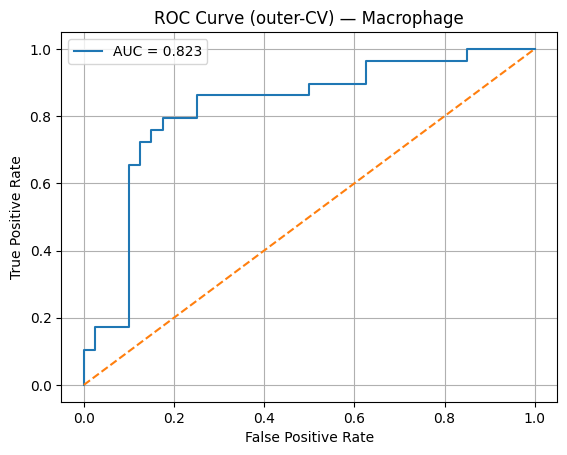

[Macrophage] outer-CV AUC = 0.823 | 8 stable features at ≥ 0.5
  Top stable features: ['f3', 'f4', 'f12', 'f15', 'f20', 'f23', 'f38', 'f47']


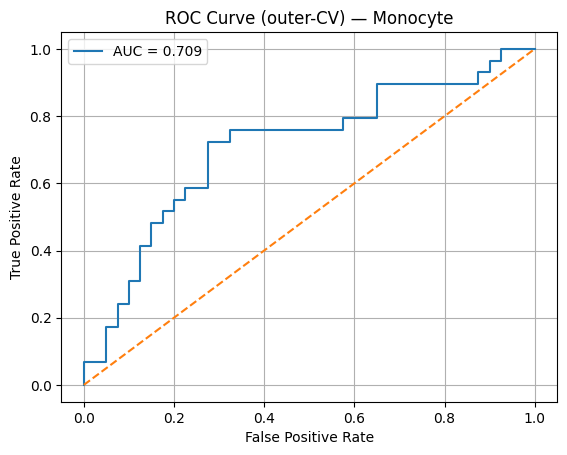

[Monocyte] outer-CV AUC = 0.709 | 4 stable features at ≥ 0.5
  Top stable features: ['f15', 'f17', 'f39', 'f41']


In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Hyperparameters
n_bootstrap = 100
stability_threshold = 0.5
C_grid = [0.01, 0.1, 1, 10]
random_seed = 42
use_class_weight_balanced = True


feature_names_by_cell = {}

def stratified_bootstrap_indices(y, rng):
    y = np.asarray(y)
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]
    boot_pos = rng.choice(idx_pos, size=len(idx_pos), replace=True)
    boot_neg = rng.choice(idx_neg, size=len(idx_neg), replace=True)
    return np.concatenate([boot_pos, boot_neg])

# Count for each feature has non-zero coefficient when using LASSO on training set
def stability_select_on_train(X_train, y_train, C, n_bootstrap=100, thr=0.7, rng_seed=None):
    rng = np.random.RandomState(rng_seed)
    p = X_train.shape[1]
    counts = np.zeros(p, dtype=float)

    for b in range(n_bootstrap):
        boot_idx = stratified_bootstrap_indices(y_train, rng)
        Xb = X_train[boot_idx]
        yb = y_train[boot_idx]

        if np.unique(yb).size < 2:
            continue

        scaler = StandardScaler().fit(Xb)
        Xb = scaler.transform(Xb)

        clf = LogisticRegression(
            penalty="l1", solver="saga", C=C, max_iter=10000,
            class_weight=("balanced" if use_class_weight_balanced else None),
            random_state=rng_seed
        )
        clf.fit(Xb, yb)
        counts += (np.abs(clf.coef_[0]) > 1e-6)

    freq = counts / n_bootstrap
    selected_idx = np.where(freq >= thr)[0]
    return selected_idx, freq

predicted_outputs_pembro_lasso = {}
feature_freq_by_cell = {}
stable_feature_table_by_cell = {}
stable_features_by_cell = {}
roc_auc_by_cell = {}
chosen_C_by_cell = {}

outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

for cell_type, Xy in filtered_clusters.items():
    X = Xy[:, :-1]
    y = Xy[:, -1].astype(int)

    ok = ~np.isnan(X).any(axis=1)
    X = X[ok]
    y = y[ok]

    p = X.shape[1]
    if cell_type in feature_names_by_cell and len(feature_names_by_cell[cell_type]) == p:
        feat_names = feature_names_by_cell[cell_type]
    else:
        feat_names = [f"f{i+1}" for i in range(p)]
        feature_names_by_cell[cell_type] = feat_names

    all_true, all_pred, all_ids = [], [], []
    agg_freq = np.zeros(p, dtype=float)
    n_outer_freq = 0
    chosen_C_list = []

    # Outer CV
    for fold_id, (tr, te) in enumerate(outer.split(X, y)):
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]

        # Inner model on outer-train only
        inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed + fold_id)
        best_inner_auc = -np.inf
        best_C = None
        best_selected = None
        best_freq = None

        for C in C_grid:
            # Stability selection on X trainning
            selected_idx, freq = stability_select_on_train(
                X_tr, y_tr, C,
                n_bootstrap=n_bootstrap,
                thr=stability_threshold,
                rng_seed=random_seed
            )

            if selected_idx.size == 0:
                continue

            # 5-fold CV
            inner_preds, inner_true = [], []
            for itr, ite in inner.split(X_tr[:, selected_idx], y_tr):
                X_tr2, X_va2 = X_tr[itr][:, selected_idx], X_tr[ite][:, selected_idx]
                y_tr2, y_va2 = y_tr[itr], y_tr[ite]

                scaler = StandardScaler().fit(X_tr2)
                X_tr2 = scaler.transform(X_tr2)
                X_va2 = scaler.transform(X_va2)

                clf = LogisticRegression(
                    penalty="l1", solver="saga", C=C, max_iter=10000,
                    class_weight=("balanced" if use_class_weight_balanced else None),
                    random_state=random_seed
                )
                clf.fit(X_tr2, y_tr2)
                inner_preds.extend(clf.predict_proba(X_va2)[:, 1])
                inner_true.extend(y_va2)

            cv_auc = roc_auc_score(inner_true, inner_preds)
            if cv_auc > best_inner_auc:
                best_inner_auc = cv_auc
                best_C = C
                best_selected = selected_idx
                best_freq = freq

        # Fallback if no C produced selected features
        if best_selected is None or best_selected.size == 0:
            scaler = StandardScaler().fit(X_tr)
            X_tr2 = scaler.transform(X_tr)
            X_te2 = scaler.transform(X_te)
            clf = LogisticRegression(
                penalty="l2", solver="lbfgs", C=1.0, max_iter=10000,
                class_weight=("balanced" if use_class_weight_balanced else None),
                random_state=random_seed
            )
            clf.fit(X_tr2, y_tr)
            all_pred.extend(clf.predict_proba(X_te2)[:, 1])
            all_true.extend(y_te)
            all_ids.extend(te)
            chosen_C_list.append(None)
        else:
            agg_freq[best_selected] += best_freq[best_selected]
            n_outer_freq += 1
            chosen_C_list.append(best_C)

            scaler = StandardScaler().fit(X_tr[:, best_selected])
            X_tr2 = scaler.transform(X_tr[:, best_selected])
            X_te2 = scaler.transform(X_te[:, best_selected])

            clf = LogisticRegression(
                penalty="l1", solver="saga", C=best_C, max_iter=10000,
                class_weight=("balanced" if use_class_weight_balanced else None),
                random_state=random_seed
            )
            clf.fit(X_tr2, y_tr)
            all_pred.extend(clf.predict_proba(X_te2)[:, 1])
            all_true.extend(y_te)
            all_ids.extend(te)

    df_out = pd.DataFrame({
        "Sample_ID": all_ids,
        "True_Label": all_true,
        "Predicted_Probability": all_pred
    }).sort_values("Sample_ID").reset_index(drop=True)
    predicted_outputs_pembro_lasso[cell_type] = df_out

    # Plot ROC-AUC
    y_true = df_out["True_Label"].to_numpy()
    y_pred = df_out["Predicted_Probability"].to_numpy()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    roc_auc_by_cell[cell_type] = auc_score
    chosen_C_by_cell[cell_type] = chosen_C_list

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve (outer-CV) — {cell_type}")
    plt.legend()
    plt.grid(True)
    plt.show()

    if n_outer_freq > 0:
        mean_freq = agg_freq / n_outer_freq
    else:
        mean_freq = np.zeros(p, dtype=float)

    feature_freq_by_cell[cell_type] = mean_freq

    tbl = pd.DataFrame({
        "feature": feat_names,
        "stability_freq": mean_freq
    }).sort_values("stability_freq", ascending=False).reset_index(drop=True)
    stable_feature_table_by_cell[cell_type] = tbl

    stable_mask = mean_freq >= stability_threshold
    stable_feats = [feat_names[i] for i in np.where(stable_mask)[0]]
    stable_features_by_cell[cell_type] = stable_feats

    print(f"[{cell_type}] outer-CV AUC = {auc_score:.3f} | "
          f"{len(stable_feats)} stable features at ≥ {stability_threshold}")
    if len(stable_feats) > 0:
        print("  Top stable features:", stable_feats[:10])
